In [33]:
# Import libraries

# Use the following line of code to install the torchvision library if not preinstalled
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

# Used to monitor running times:
import time

In [2]:
# Define some useful functions

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [3]:
IMAGE_SIZE = 28 # let's try with the original size first. This row can be used to resize the images

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [4]:
# Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 
# The data set consists of 4 files contained within Fashion-MNIST.zip:
# train-images-idx3-ubyte.gz: training set with 60,000 images (26 MBytes)
# train-labels-idx1-ubyte.gz: training set with 60,000 labels (29 KBytes)
# t10k-images-idx3-ubyte.gz: test set with 10,000 images (4.3 MBytes )
# t10k-labels-idx1-ubyte.gz: test set with 10,000 labels (5.1 KBytes)

train_dataset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)

0it [00:00, ?it/s]

26427392it [00:00, 37553674.93it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 151996.58it/s]           
  2%|▏         | 98304/4422102 [00:00<00:04, 944677.69it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


4423680it [00:00, 20983900.64it/s]                            
8192it [00:00, 139368.93it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw
Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [5]:
validation_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

In [6]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

In [15]:
element = 4

# Label for the data element
train_dataset[element][1]

0

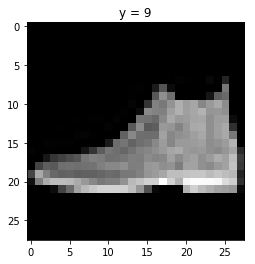

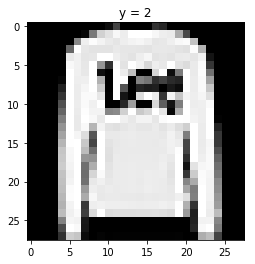

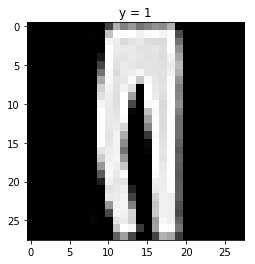

In [57]:
# Take a screen shot of the first three images of the validation dataset
for i in range(3): # images for the first data elements in validation data
    show_data(validation_dataset[i])
    plt.show()

In [30]:
# Build a Two Convolutional Neural Network Class

number_of_classes=10
#This comes from the dataset, which has the following classes
#Label Description
#0 T-shirt/top
#1 Trouser
#2 Pullover
#3 Dress
#4 Coat
#5 Sandal
#6 Shirt
#7 Sneaker
#8 Bag
#9 Ankle boot

# The subsequent parameters of the neural network can be varied to optimise the model

# Number of channels in the outputs of the convolution layers
h = IMAGE_SIZE
w = IMAGE_SIZE
#print(h,w)
channels_1 = 16 # channels coming from the first convolutional and pooling layer
channels_2 = 32 # channels coming from the second convolutional and pooling layer

# Parameters for the convolution layers
kernel_1 = 5 # MNIST with 16x16 worked well with 5, but we could try a larger kernel since the image size is also larger
kernel_2 = 5 # MNIST with 16x16 worked well with 5, but we could try a larger kernel since the image size is also larger
dilation_1 = 1
dilation_2 = 1
stride_1 = 1
stride_2 = 1
pad_1 = 0
pad_2 = 0
kernel_maxpooling = 2
stride_maxpooling = kernel_maxpooling

# To assess the dimensions of the layers, use the following function

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

dim1=conv_output_shape((h,w), kernel_size=kernel_1, stride=stride_1, pad=pad_1, dilation=dilation_1) # 1st convolution layer, stride default is = 1 (https://pytorch.org/docs/stable/nn.html)
print("Dimensions after 1st convolutional layer:",dim1)
dim2=conv_output_shape(dim1, kernel_size=kernel_maxpooling, stride=stride_maxpooling, pad=0, dilation=1) # 1st maxpooling, stride default is kernel size (https://pytorch.org/docs/stable/nn.html)
print("Dimensions after 1st pooling layer:",dim2)
dim3=conv_output_shape(dim2, kernel_size=kernel_2, stride=stride_2, pad=pad_2, dilation=dilation_2) # 2nd convolution layer
print("Dimensions after 2nd convolutional layer:",dim3)
dim4=conv_output_shape(dim3, kernel_size=kernel_maxpooling, stride=stride_maxpooling, pad=0, dilation=1) # 2nd maxpooling
print("Dimensions after 2nd pooling layer:",dim4)
out_2_size = dim4[0]*dim4[1]
#print(out_2_size)

# Build a class CNN_batch(nn.Module):
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=kernel_1, stride=stride_1, padding=pad_1)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=kernel_maxpooling)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=kernel_2, stride=stride_2, padding=pad_2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=kernel_maxpooling)
        self.fc1 = nn.Linear(out_2 * out_2_size, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(number_of_classes) #nn.BatchNorm1d(10)
     
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

Dimensions after 1st convolutional layer: (24, 24)
Dimensions after 1st pooling layer: (12, 12)
Dimensions after 2nd convolutional layer: (8, 8)
Dimensions after 2nd pooling layer: (4, 4)


In [37]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

In [52]:
N_epochs = 10 # increase later
start = time.time()

# Create the model object using CNN class
model_batch=CNN_batch(out_1=channels_1, out_2=channels_2)

# Define the loss function, the optimizer and the dataset loader 
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

# Train model
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=N_epochs,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

end = time.time()
print("Model training time in minutes:",float(end-start)/60)

Model training time in minutes: 7.941099043687185


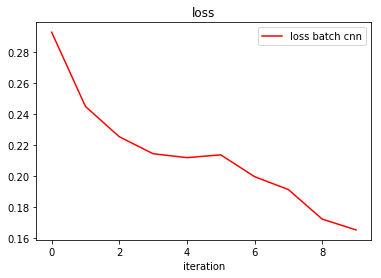

In [53]:
# Plot the loss and accuracy

plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()
plt.show()

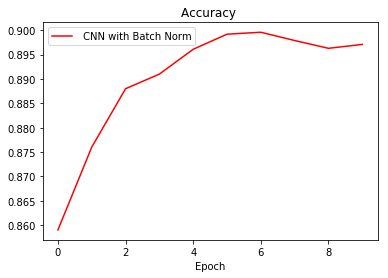

In [54]:
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()

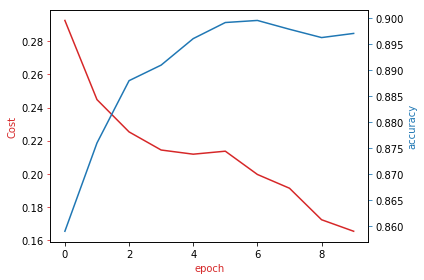

In [55]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list_batch, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list_batch, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

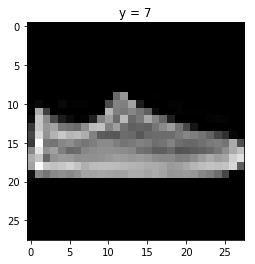

yhat:  5


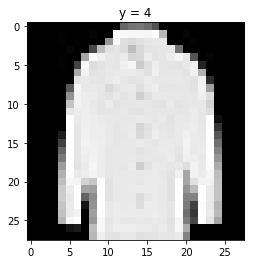

yhat:  2


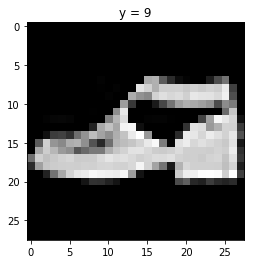

yhat:  5


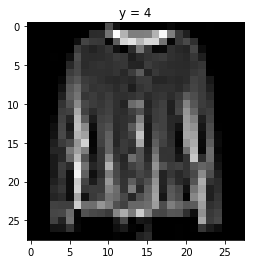

yhat:  6


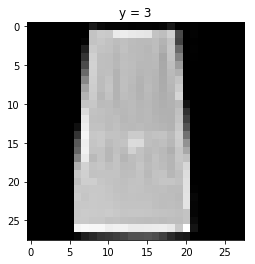

yhat:  6


In [56]:
# Plot the 5 first mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model_batch(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y.item()))
        plt.show()
        print("yhat: ",yhat.item())
        count += 1
    if count >= 5:
        break